# Hybid Dark Sector Demo
In this notebook, I explore the CAMB-HDS code with some simple science applications.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import camb

## 1. Reproduce Figures from https://arxiv.org/pdf/2211.13653.

In [3]:
# Standard cosmological parameters
h = 0.6756
omegabh2 = 0.022
omegach2 = 0.12
As = 2.215e-9
ns = 0.962

cases = [8, 10, 15, "LCDM"] # Each case represents a different initial value of the scalar field phi

results = []
for case in cases:
	if case == "LCDM":
		cosmo = camb.set_params(
			# Background
			H0=100*h, ombh2=omegabh2, omch2=omegach2, TCMB=2.7255,
			# Dark Energy
			dark_energy_model='fluid',
			# Neutrinos
			omnuh2=0, num_nu_massless=3.044, num_nu_massive=0,
			nu_mass_degeneracies=[0], nu_mass_numbers=[0],
			# Initial Power Spectrum
			As=As, ns=ns, 
			tau=0.0544,
			YHe=0.246, WantTransfer=True,
		)
	else:
		cosmo = camb.set_params(
			# Background
			H0=100*h, ombh2=omegabh2, omch2=omegach2, TCMB=2.7255,
			# Dark Energy
			dark_energy_model='HybridQuintessence', phi_i=case, alpha=1.0,
			# Neutrinos
			omnuh2=0, num_nu_massless=3.044, num_nu_massive=0,
			nu_mass_degeneracies=[0], nu_mass_numbers=[0],
			# Initial Power Spectrum
			As=As, ns=ns,
			tau=0.0544,
			YHe=0.246, WantTransfer=True
		)
	cosmo.NonLinear = camb.model.NonLinear_none
	results.append(camb.get_results(cosmo))

: 

Text(0, 0.5, '$\\Omega$')

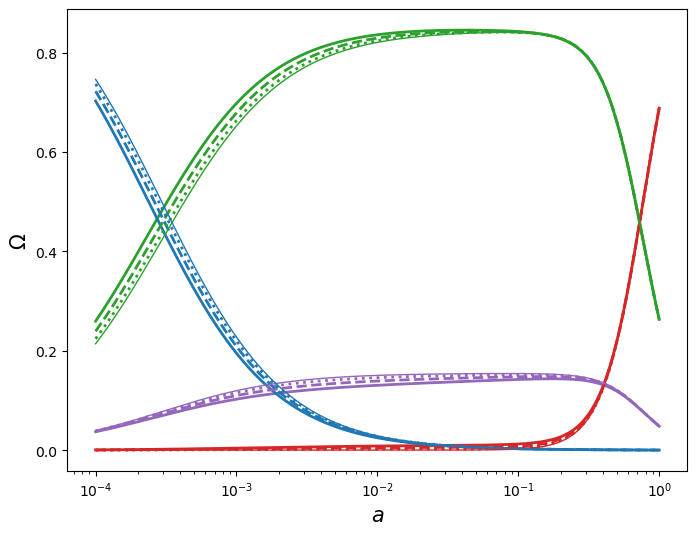

In [3]:
# Figure 1, left panel: relative densities of all species
plt.figure(figsize=(8, 6))
scale_factor = np.logspace(-4, 0, 10000)
redshift = 1/scale_factor - 1
lws = [2, 2, 2, 1]
lss = ['-', '--', ':', '-']
colors = ['tab:red', 'tab:green', 'tab:purple', 'black']
legend_labels = [fr"$\phi_i = {case}$" if case != "LCDM" else fr"$\Lambda CDM$" for case in cases]
for case, result, ls, lw, color, label in zip(cases, results, lss, lws, colors, legend_labels):
    # rho_de, w_de = result.get_dark_energy_rho_w(scale_factor)
    rhos = result.get_background_densities(scale_factor)
    plt.semilogx(scale_factor, rhos['de']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:red')
    plt.semilogx(scale_factor, rhos['cdm']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:green')
    plt.semilogx(scale_factor, rhos['baryon']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:purple')
    plt.semilogx(scale_factor, (rhos['photon'] + rhos['neutrino'])/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:blue')

plt.xlabel(r"$a$", fontsize=15)
plt.ylabel(r"$\Omega$", fontsize=15)

Text(0, 0.5, '$\\rho_\\phi$')

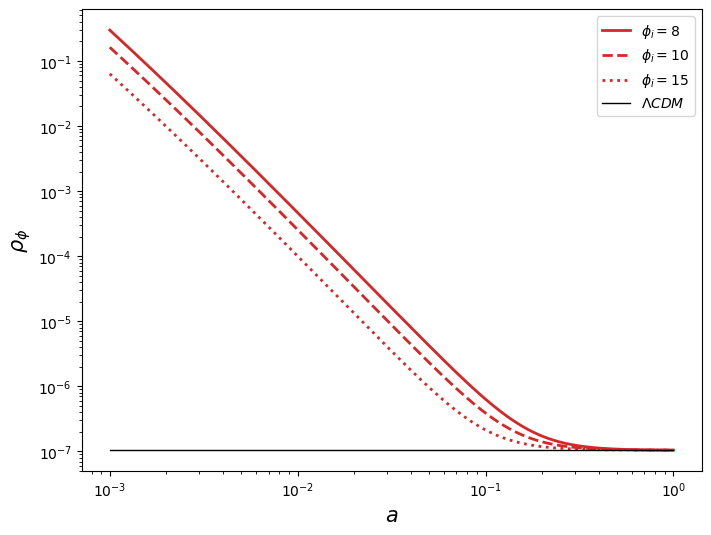

In [4]:
# Figure 1, top right panel: dark energy density
plt.figure(figsize=(8, 6))
scale_factor = np.logspace(-3, 0, 1000)
redshift = 1/scale_factor - 1
lws = [2, 2, 2, 1]
lss = ['-', '--', ':', '-']
colors = ['tab:red']*3 + ['black']
legend_labels = [fr"$\phi_i = {case}$" if case != "LCDM" else fr"$\Lambda CDM$" for case in cases]
for case, result, ls, lw, color, label in zip(cases, results, lss, lws, colors, legend_labels):
    rhos = result.get_background_densities(scale_factor)
    plt.loglog(scale_factor, rhos['de']/scale_factor**4, ls=ls, lw=lw, label=label, color=color)

plt.legend()
plt.xlabel(r"$a$", fontsize=15)
plt.ylabel(r"$\rho_\phi$", fontsize=15)

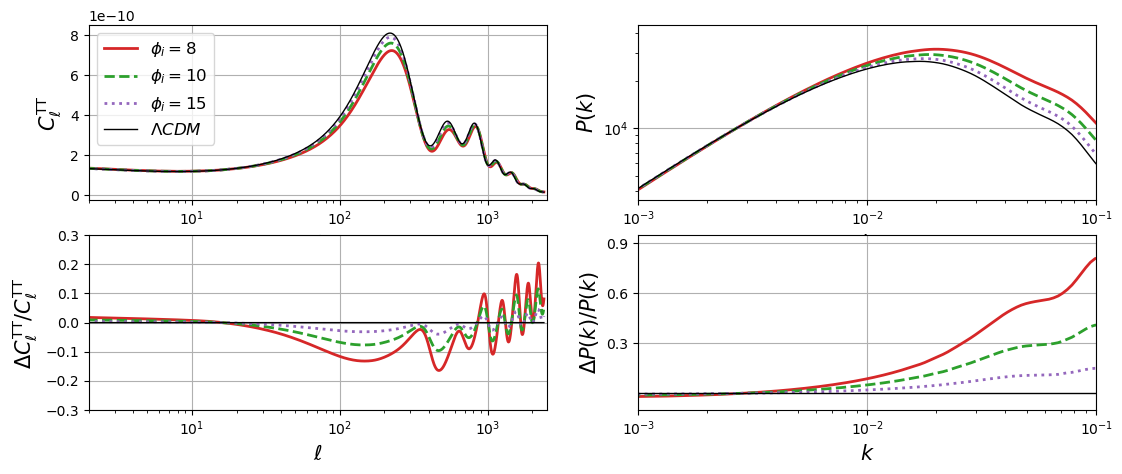

In [5]:
# Figures 3 (right panels) and 5 (right panels): Matter and CMB TT power spectra
fig, axs = plt.subplots(2, 2, figsize=(13, 5))
scale_factor = np.logspace(-4, 0, 10000)
redshift = 1/scale_factor - 1
lws = [2, 2, 2, 1]
lss = ['-', '--', ':', '-']
colors = ['tab:red', 'tab:green', 'tab:purple', 'black']
legend_labels = [fr"$\phi_i = {case}$" if case != "LCDM" else fr"$\Lambda CDM$" for case in cases]
c_ells_lcdm = results[-1].get_lensed_scalar_cls()[:,0]
pk_lcdm = results[-1].get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2][0]
for case, result, ls, lw, color, label in zip(cases, results, lss, lws, colors, legend_labels):
    c_ells = result.get_lensed_scalar_cls()[:,0]
    ks = result.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pk = result.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2][0]
    axs[0, 0].semilogx(c_ells[2:], ls=ls, lw=lw, label=label, color=color)
    axs[1, 0].semilogx((c_ells[2:] - c_ells_lcdm[2:])/c_ells_lcdm[2:], ls=ls, lw=lw, label=label, color=color)
    axs[0, 1].loglog(ks, pk, ls=ls, lw=lw, label=label, color=color)
    axs[1, 1].semilogx(ks, (pk-pk_lcdm)/pk_lcdm, ls=ls, lw=lw, label=label, color=color)
    
axs[0, 0].legend(loc='upper left', fontsize=12)
axs[0, 0].set_xlabel(r"$\ell$", fontsize=15)
axs[0, 0].set_ylabel(r"$C_\ell^\mathrm{TT}$", fontsize=15)
axs[1, 0].set_xlabel(r"$\ell$", fontsize=15)
axs[1, 0].set_ylabel(r"$\Delta C_\ell^\mathrm{TT} / C_\ell^\mathrm{TT}$", fontsize=15)
axs[0, 1].set_xlabel(r"$k$", fontsize=15)
axs[0, 1].set_ylabel(r"$P(k)$", fontsize=15)
axs[0, 0].set_xlim([2, 2500])
axs[1, 0].set_xlim([2, 2500])
axs[1, 0].set_ylim([-0.3, 0.3])
axs[0, 1].set_xlim([1e-3, 1e-1])
axs[1, 1].set_xlim([1e-3, 1e-1])
axs[1, 1].set_yticks([0.3, 0.6, 0.9])
axs[0, 1].set_ylim([3.5e3, 4.5e4])
axs[1, 1].set_ylim([-0.1, 0.95])
axs[1, 1].set_xlabel(r"$k$", fontsize=15)
axs[1, 1].set_ylabel(r"$\Delta P(k)/P(k)$", fontsize=15)
for ax in axs.flatten(): ax.grid()
plt.savefig("HDS_CAMB.pdf")

## 2. Exploring $w_\mathrm{eff}$

From the Klein-Gordon equation,

$$ \dot\rho_\phi + 3H\rho_\phi(1 + w_\phi) = -\frac{\dot\phi}{\phi}\rho_\chi $$

We can rewrite it as

$$ \dot\rho_\phi + 3H\rho_\phi\left(1 + w_\phi + \frac{\dot\phi}{3H\phi}\frac{\rho_\chi}{\rho_\phi} \right) = 0 $$

Where we can define an effective dark energy equation of state,

$$ w_\mathrm{eff} = w_\phi + \frac{\dot\phi}{3H\phi}\frac{\rho_\chi}{\rho_\phi} $$

In [17]:
alphas = [0.5, 1.0, 1.5] # Each case represents a different initial value of the scalar field phi
results = []

for alpha in alphas:
    cosmo = camb.set_params(
        # Background
        H0=100*h, ombh2=omegabh2, omch2=omegach2, TCMB=2.7255,
        # Dark Energy
        dark_energy_model='HybridQuintessence', phi_i=8, alpha=alpha,
        # Neutrinos
        omnuh2=0, num_nu_massless=3.044, num_nu_massive=0,
        nu_mass_degeneracies=[0], nu_mass_numbers=[0],
        # Initial Power Spectrum
        As=As, ns=ns,
        tau=0.0544,
        YHe=0.246, WantTransfer=True
    )
    cosmo.NonLinear = camb.model.NonLinear_none
    results.append(camb.get_results(cosmo))

Text(0, 0.5, 'w')

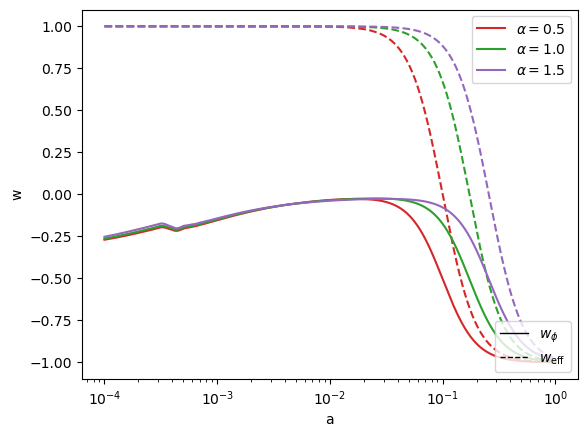

In [18]:
# Plotting w_eff
fig, ax = plt.subplots()
legend_labels = [fr"$\alpha = {alpha}$" for alpha in alphas]
colors = ['tab:red', 'tab:green', 'tab:purple']
for result, label, color in zip(results, legend_labels, colors):
    if label == r"$\Lambda CDM$": continue
    rhos = result.get_background_densities(scale_factor)
    H = scale_factor*result.h_of_z(1/scale_factor - 1)
    _, w_de = result.get_dark_energy_rho_w(scale_factor)
    rho_de = rhos['de']/scale_factor**4
    rho_cdm = rhos['cdm']/scale_factor**4
    de = result.Params.DarkEnergy
    phi_interpolator = interp1d(de.sampled_a, de.phi_a)
    phi_prime_interpolator = interp1d(de.sampled_a, de.phidot_a)
    phi = phi_interpolator(scale_factor)
    phi_prime = phi_prime_interpolator(scale_factor)
    w_eff = w_de + de.alpha * phi_prime * rho_cdm / (phi * 3 * H * rho_de)
    plt.semilogx(scale_factor, w_eff, label=label, color=color)
    plt.semilogx(scale_factor, w_de, ls='--', color=color)

l = ax.legend()
ax.add_artist(l)
# Custom legend
custom_lines = [mpl.lines.Line2D([0], [0], color="black", lw=1, ls='-'), \
                mpl.lines.Line2D([0], [0], color="black", lw=1, ls='--'),]
ax.legend(handles=custom_lines, labels=[r"$w_\phi$", r"$w_\mathrm{eff}$"], loc="lower right")
plt.xlabel("a")
plt.ylabel(r"w")